The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. This notebook illustrates the use of Spark in SWAN to analyze the monitoring data available on HDFS and plots a heatmap of loadAvg across machines in a particular service.

### Connect to the cluster

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import from_unixtime, when, col
from pyspark.sql.types import *
from pyspark.sql.functions import from_json

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data
*path_on_hdfs_to_your_data*

In [3]:
df = spark.read.json("/user/rucio01/traces/traces.2018*")

### check the structure

In [4]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- account: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- catStart: double (nullable = true)
 |-- clientState: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- datasetName: string (nullable = true)
 |-- datasetScope: string (nullable = true)
 |-- dataset_scope: string (nullable = true)
 |-- duid: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- eventVersion: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- filesize: string (nullable = true)
 |-- guid: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- localSite: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pq: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- relativeStart: double (nullable = true)
 |-- remoteSite: string (nullable = true)
 |-- scope: string (nullable = true)
 |-- stateReason: string (nullab

### Filter for loadAvg
_https://metricmgr.cern.ch/metric/20002/_

In [5]:
df.head()

Row(_corrupt_record=None, account=None, appid=u'3772225596', catStart=1514761197.84869, clientState=u'DONE', dataset=u'panda.um.data17_13TeV.00340030.physics_Main.deriv.DAOD_BPHY6.f889_m1902_p3267_tid12608781_00.169436420', datasetName=None, datasetScope=None, dataset_scope=None, duid=None, eventType=u'get_sm', eventVersion=u'pilot3', filename=u'DAOD_BPHY6.12608781._000245.pool.root.1.panda.um_002', filesize=u'57392255', guid=u'4E82F48B91AAC946B8E897E3CCFE62C7', hostname=u'c-8-23.aglt2.org', ip=u'192.41.230.149', localSite=u'AGLT2_DATADISK', name=None, pq=u'AGLT2_SL6', protocol=u'lsm', relativeStart=1514761197.850914, remoteSite=u'AGLT2_DATADISK', scope=u'panda', stateReason=u'OK', suspicious=u'0', taskid=u'12608781', timeEnd=1514761199.339337, timeStart=1514761014.277093, traceId=u'7d679dc663e44880a812b0d709e9b7ee', traceIp=u'::ffff:192.41.230.149', traceTimeentry=u'2017-12-31T23:00:00.007341', traceTimeentryUnix=1514761200.007341, transferEnd=None, transferStart=1514761197.850914, ur

### Create temporary table view

In [6]:
# body_schema = spark.read.json(df_loadAvg.rdd.map(lambda row: row.body)).schema
df.createOrReplaceTempView("traces")

### Do the heavylifting in spark and collect aggregated view to panda DF

In [7]:
df_pandas = spark.sql("SELECT dataset, \
                               from_unixtime(traceTimeentryUnix, 'YYYY-MM-dd') AS dt, \
                               count(*) as amount \
                               FROM traces \
                               WHERE eventType = 'download' AND from_unixtime(traceTimeentryUnix, 'YYYY-MM-dd') >= date_add(current_date(), -30)\
                               GROUP BY 1, 2 \
                               HAVING count(1) BETWEEN 50 AND 10000\
                               ORDER BY 3 DESC")\
                    .toPandas()

In [8]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
df_pandas

dataset  \
0      mc15_13TeV.364370.Sherpa_222_NNPDF30NNLO_llvvjj_ss_EW6_CSSKIN.evgen.EVNT.e6582                                                                  
1      user.ljiang.data.data16_13TeV.00302053.physics_Main.DAOD.r9264_p3083_EXT0                                                                       
2      group.phys-higgs.mc16_13TeV.410470.CAOD_HIGG5D1.e6337_e5984_s3126_r10201_r10210_p3371.31-10_CxAOD.root                                          
3      user.adbailey.jetjet_JZ1.grid.AOD.LCJets.Run1_EXT0                                                                                              
4      group.phys-higgs.mc16_13TeV.363360.CAOD_HIGG5D1.e5983_e5984_s3126_r10201_r10210_p3371.31-10_CxAOD.root                                          
5      user.cylin.Pythia_JZ5W.MyTrk.v10_OUTPUT                                                                                                         
6      group.phys-higgs.mc16_13TeV.361028.CAOD_HIGG5D1.e3569_s3126_r10201_r10210_p3371.31-10_CxAOD.root                                                
7      data16_13TeV.periodD.physics_Main.PhysCont.DAOD_STDM3.grp16_v11_p3298                                                                           
8      group.phys-higgs.mc16_13TeV.361031.CAOD_HIGG5D1.e3569_s3126_r10201_r10210_p3371.31-10_CxAOD.root                                                
9      data16_13TeV.periodL.physics_Main.PhysCont.DAOD_STDM3.grp16_v11_p3298                                                                           
10     mc15_13TeV.364371.Sherpa_222_NNPDF30NNLO_llvvjj_ss_EW6_CKKW30.evgen.EVNT.e6582                                                                  
11     user.tnitta.mc15_14TeV.363655.MGPy8EG_N30NLO_Wtaunu_Ht140_280_CFilterBVeto.e9997.p3401.v1_DAOD_TRUTH1.363655.root                               
12     user.tnitta.mc15_14TeV.363660.MGPy8EG_N30NLO_Wtaunu_Ht500_700_CVetoBVeto.e9997.p3401.v1p1_DAOD_TRUTH1.363660.root                               
13     user.mverissi.NMF.fro_50_all_bins_td                                                                                                            
14     None                                                                                                                                            
15     user.tnitta.mc15_14TeV.363657.MGPy8EG_N30NLO_Wtaunu_Ht280_500_CVetoBVeto.e9997.p3401.v1_DAOD_TRUTH1.363657.root                                 
16     group.phys-higgs.mc16_13TeV.364170.CAOD_HIGG5D1.e5340_s3126_r10201_r10210_p3371.31-10_CxAOD.root                                                
17     user.tnitta.mc15_14TeV.363671.MGPy8EG_N30NLO_Wtaunu_Ht2000_E_CMS_BFilter.e9997.p3401.v1_DAOD_TRUTH1.363671.root                                 
18     user.tnitta.mc15_14TeV.363658.MGPy8EG_N30NLO_Wtaunu_Ht280_500_CFilterBVeto.e9997.p3401.v1_DAOD_TRUTH1.363658.root                               
19     user.tnitta.mc15_14TeV.363668.MGPy8EG_N30NLO_Wtaunu_Ht1000_2000_BFilter.e9997.p3401.v1_DAOD_TRUTH1.363668.root                                  
20     user.tnitta.mc15_14TeV.363661.MGPy8EG_N30NLO_Wtaunu_Ht500_700_CFilterBVeto.e9997.p3401.v1_DAOD_TRUTH1.363661.root                               
21     user.aleopold.hgtd_tt_mu200_vecRPT.2018_04_08_0010_HGTDHitAnalysis                                                                              
22     None                                                                                                                                            
23     user.tnitta.mc15_14TeV.363662.MGPy8EG_N30NLO_Wtaunu_Ht500_700_BFilter.e9997.p3401.v1p1_DAOD_TRUTH1.363662.root                                  
24     user.aezhilov.mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.v11.1_histo.root                                                           
25     user.cylin.Pythia_JZ3W.MyTrk.v10_OUTPUT                                                                                                         
26     group.phys-higgs.mc16_13TeV.36

In [9]:
df_pandas = spark.sql("SELECT dataset, from_unixtime(traceTimeentryUnix, 'YYYY-MM-dd') AS dt, \
                               count(*) \
                               FROM traces \
                               WHERE dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%') AND eventType = 'download' AND from_unixtime(traceTimeentryUnix, 'YYYY-MM-dd') >= date_add(current_date(), -30)\
                               GROUP BY 1,2 \
                               ORDER BY 1")\
                    .toPandas()

In [10]:


df_pandas.dtypes



dataset     object
dt          object
count(1)    int64 
dtype: object

In [11]:
df_pandas['dt'] = df_pandas['dt'].astype('datetime64[ns]')

In [12]:
df_pandas.dtypes

dataset     object        
dt          datetime64[ns]
count(1)    int64         
dtype: object

https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot

In [113]:
df_pandas_sample = df_pandas['dataset'].sample(n=50, random_state=3)
ser = pd.DataFrame(df_pandas_sample.values)
ser.drop_duplicates()
ser.columns = ['dataset']
ser



dataset
0   data17_13TeV.00326834.physics_Main.deriv.DAOD_EGAM2.f837_m1824_p3336                                                                      
1   mc16_13TeV.344753.Pythia8EvtGen_A14NNPDF23LO_WH1000_Zllgam.deriv.NTUP_PILEUP.e5428_e5984_s3126_r9781_r9778_p3384                          
2   mc16_13TeV.309008.Pythia8EvtGen_A14NNPDF23LO_WeHNL50_20G_lt01dd_lepfilt_ch3.deriv.NTUP_PILEUP.e6165_e5984_a875_r9364_r9315_p3288          
3   mc16_13TeV.301005.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_800M1000.merge.NTUP_PILEUP.e3649_s3126_r10201_r10210_p3384_p3385                  
4   mc16_13TeV.343698.aMcAtNloHerwigppEvtGen_UEEE5_CTEQ6L1_CT10ME_Xhh_m300_yybb.merge.NTUP_PILEUP.e5334_e5984_a875_r9781_r9778_p3384_p3385    
5   mc16_13TeV.410472.PhPy8EG_A14_ttbar_hdamp258p75_dil.deriv.NTUP_PILEUP.e6348_e5984_s3126_r9781_r9778_p3384                                 
6   mc16_13TeV.410372.aMcAtNloPythia8EvtGen_MEN30NLO_A14Var3UpN23LO_ttmumu.deriv.NTUP_PILEUP.e6125_e5984_s3126_r10201_r10210_p3384            
7   mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                             
8   mc16_13TeV.301023.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYmumu_400M600.deriv.DAOD_HIGG4D4.e3649_e5984_s3126_r9364_r9315_p3401                  
9   mc16_13TeV.341542.aMcAtNloPythia8EvtGen_A14NNPDF23LO_Hplus4FS_H225_tb.deriv.NTUP_PILEUP.e4336_e5984_a875_r9364_r9315_p3288                
10  mc16_13TeV.345161.Pythia8EvtGen_A14NNPDF23LO_WH2500_Zllgam.merge.NTUP_PILEUP.e5779_e5984_s3126_r9781_r9778_p3384_p3385                    
11  mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75_nonallhad.merge.NTUP_PILEUP.e5458_s3126_r9364_r9315_p3127_p3126               
12  mc15_13TeV.364153.Sherpa_221_NNPDF30NNLO_Znunu_MAXHTPTV280_500_BFilter.evgen.EVNT.e5308                                                   
13  mc16_13TeV.361604.PowhegPy8EG_CT10nloME_AZNLOCTEQ6L1_ZZvvll_mll4.merge.NTUP_PILEUP.e4475_e5984_s3126_r10201_r10210_p3384_p3385            
14  mc16_13TeV.410642.PhPy8EG_A14_tchan_lept_top.deriv.DAOD_EXOT17.e6536_e5984_a875_r9364_r9315_p3371                                         
15  mc16_13TeV.342556.PowhegPy8EG_CT10nloME_AZNLOCTEQ6L1_ZZllll_mll4_m4l_100_150.merge.NTUP_PILEUP.e4366_e6174_s3126_r9364_r9315_p3127_p3126  
16  mc16_13TeV.344314.MadGraphPythia8EvtGen_A14NNPDF23LO_zphxx_gg_mzp10_mx10.deriv.NTUP_PILEUP.e5167_e5984_a875_r9781_r9778_p3384             
17  mc16_13TeV.364172.Sherpa_221_NNPDF30NNLO_Wenu_MAXHTPTV0_70_BFilter.deriv.NTUP_PILEUP.e5340_s3126_r10201_r10210_p3384                      
18  mc15_13TeV.395156.MGPy8EG_A14N23LO_SM_N2N1_253_250_2L2MET75_MadSpin.evgen.log.e6588                                                       
19  mc16_13TeV.364338.Sherpa_222_NNPDF30NNLO_WpWpWn_oslvlvjj_EW6.merge.NTUP_PILEUP.e6377_e5984_s3126_r9781_r9778_p3384_p3385                  
20  mc16_13TeV.342327.PowhegPythia8EvtGen_CT10_AZNLOCTEQ6L1_ggH1000W30_tautauhh.merge.NTUP_PILEUP.e4284_e5984_s3126_r10201_r10210_p3384_p3385 
21  mc16_13TeV.301054.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYtautau_3000M3500.deriv.DAOD_HIGG4D4.e3649_s3126_r9364_r9315_p3401                    
22  mc16_13TeV.363649.MGPy8EG_N30NLO_Wtaunu_Ht0_70_CFilterBVeto.merge.NTUP_PILEUP.e4944_e5984_s3126_r9364_r9315_p3288_p3126                   
23  mc16_13TeV.364178.Sherpa_221_NNPDF30NNLO_Wenu_MAXHTPTV140_280_BFilter.deriv.NTUP_PILEUP.e5340_e5984_s3126_r10201_r10210_p3384             
24  mc16_13TeV.410000.PowhegPythiaEvtGen_P2012_ttbar_hdamp172p5_nonallhad.merge.AOD.e5602_s3126_r10201_r10210                                 
25  mc16_13TeV.364182.Sherpa_221_NNPDF30NNLO_Wenu_MAXHTPTV500_1000.merge.NTUP_PILEUP.e5340_s3126_r10201_r10210_p3384_p3385                    
26  mc16_13TeV.364215.Sherpa_221_NN30NNLO_Ztt_Mll10_40_MAXHTPTV280_E_CMS_BFilter.merge.NTUP_PILEUP.e5421_e5984_s3126_r10201_r10210_p3384_p3385
27  mc16_13TeV.342327.PowhegPythia8EvtGen_CT10_AZNLOCTEQ6L1_ggH1000W30_tautauhh.deriv.DAOD_HIGG4D4.e4284_s3126_r9364_r9315_p3401   

In [114]:
merged = df_pandas.merge(ser, on='dataset', how='inner', indicator=True)
temp = merged.copy(deep=True)
merged


dataset  \
0    data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                      
1    data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                      
2    data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                      
3    data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                      
4    data17_13TeV.00326834.physics_Main.deriv.DAOD_EGAM2.f837_m1824_p3336                                                                         
5    data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                   
6    data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                   
7    data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                   
8    data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                   
9    data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                   
10   data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                   
11   mc15_13TeV.345306.PowhegHerwig7EvtGen_NNLOPS_nnlo_30_ggH125_gamgam.merge.DAOD_TRUTH4.e5853_p3135                                             
12   mc15_13TeV.345306.PowhegHerwig7EvtGen_NNLOPS_nnlo_30_ggH125_gamgam.merge.DAOD_TRUTH4.e5853_p3135                                             
13   mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                                
14   mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                                
15   mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                                
16   mc15_13TeV.363635.MGPy8EG_N30NLO_Wmunu_Ht280_500_BFilter.merge.NTUP_PILEUP.e4944_s2726_r7772_r7676_p2799                                     
17   mc15_13TeV.364153.Sherpa_221_NNPDF30NNLO_Znunu_MAXHTPTV280_500_BFilter.evgen.EVNT.e5308                                                      
18   mc15_13TeV.364153.Sherpa_221_NNPDF30NNLO_Znunu_MAXHTPTV280_500_BFilter.evgen.EVNT.e5308                                                      
19   mc15_13TeV.395023.MGPy8EG_A14N23LO_SM_N2C1p_203_200_2L2MET75_MadSpin.evgen.log.e6587                                                         
20   mc15_13TeV.395156.MGPy8EG_A14N23LO_SM_N2N1_253_250_2L2MET75_MadSpin.evgen.log.e6588                                                          
21   mc16_13TeV.301005.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_800M1000.merge.NTUP_PILEUP.e3649_s3126_r10201_r10210_p3384_p3385                     
22   mc16_13TeV.301005.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_800M1000.merge.NTUP_PILEUP.e3649_s3126_r10201_r10210_p3384_p3385                     
23   mc16_13TeV.301005.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_800M1000.merge.NTUP_PILEUP.e3649_s3126_r10201_r10210_p3384_p3385                     
24   mc16_13TeV.301015.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_3500M4000.merge.NTUP_PILEUP.e3649_s3126_r9364_r9315_p3127_p3126                      
25   mc16_13TeV.301015.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_3500M4000.merge.NTUP_PILEUP.e3649_s3126_r9364_r9315_p3127_p3126                      
26   mc16_13TeV.301015.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_3500M4000.merge.NTUP_PILEUP.e3649_s3126_r9364_r9315_p3127_p3126                      
27   mc16_13TeV.3010

(array([ 736792.,  736799.,  736806.,  736813.,  736820.]),
 <a list of 5 Text xticklabel objects>)

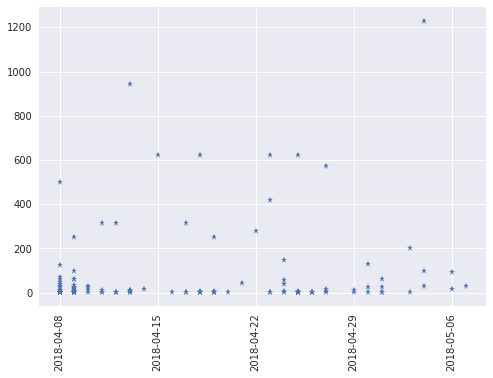

In [115]:
plt.plot(merged['dt'], merged['count(1)'], '*')
plt.xticks(rotation='vertical')

In [116]:
merged.set_index('dt', inplace=True)
grouped = merged.groupby('dataset')

In [117]:
gr = grouped.groups

dataset
data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                       AxesSubplot(0.125,0.2;0.775x0.68)
data17_13TeV.00326834.physics_Main.deriv.DAOD_EGAM2.f837_m1824_p3336                                                                          AxesSubplot(0.125,0.2;0.775x0.68)
data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                    AxesSubplot(0.125,0.2;0.775x0.68)
mc15_13TeV.345306.PowhegHerwig7EvtGen_NNLOPS_nnlo_30_ggH125_gamgam.merge.DAOD_TRUTH4.e5853_p3135                                              AxesSubplot(0.125,0.2;0.775x0.68)
mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                                 AxesSubplot(0.125,0.2;0.775x0.68)
mc15_13TeV.363635.MGPy8EG_N30NLO_Wmunu_Ht280_500_BFilter.merge.NTUP_PILEUP.e4944_s2726_r7772_r7676_p2799        

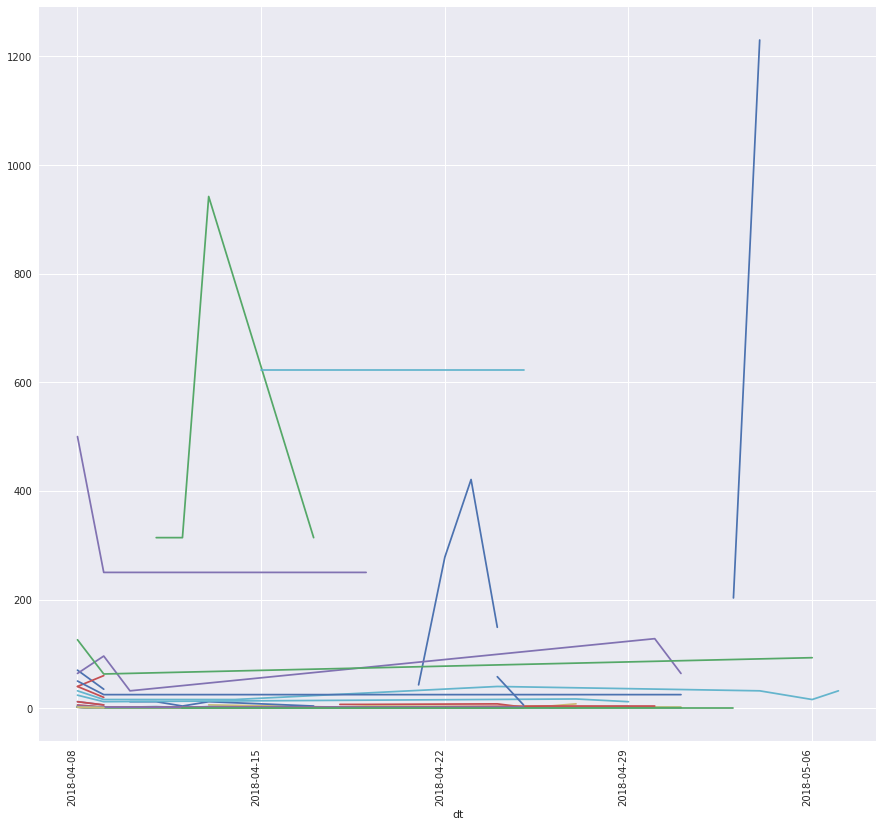

In [118]:
grouped['count(1)'].plot(legend=False, rot=90, figsize=(15,15))

In [119]:
grouped['count(1)'].describe()

count  \
dataset                                                                                                                                             
data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                     4.0     
data17_13TeV.00326834.physics_Main.deriv.DAOD_EGAM2.f837_m1824_p3336                                                                        1.0     
data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                  6.0     
mc15_13TeV.345306.PowhegHerwig7EvtGen_NNLOPS_nnlo_30_ggH125_gamgam.merge.DAOD_TRUTH4.e5853_p3135                                            2.0     
mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                               3.0     
mc15_13TeV.363635.MGPy8EG_N30NLO_Wmunu_Ht280_500_BFilter.merge.NTUP_PILEUP.e4944_s2726_r7772_r7676_p2799                                    1.0     
mc15_13TeV.364153.Sherpa_221_NNPDF30NNLO_Znunu_MAXHTPTV280_500_BFilter.evgen.EVNT.e5308                                                     2.0     
mc15_13TeV.395023.MGPy8EG_A14N23LO_SM_N2C1p_203_200_2L2MET75_MadSpin.evgen.log.e6587                                                        1.0     
mc15_13TeV.395156.MGPy8EG_A14N23LO_SM_N2N1_253_250_2L2MET75_MadSpin.evgen.log.e6588                                                         1.0     
mc16_13TeV.301005.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_800M1000.merge.NTUP_PILEUP.e3649_s3126_r10201_r10210_p3384_p3385                    3.0     
mc16_13TeV.301015.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYee_3500M4000.merge.NTUP_PILEUP.e3649_s3126_r9364_r9315_p3127_p3126                     4.0     
mc16_13TeV.301023.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYmumu_400M600.deriv.DAOD_HIGG4D4.e3649_e5984_s3126_r9364_r9315_p3401                    1.0     
mc16_13TeV.301054.PowhegPythia8EvtGen_AZNLOCTEQ6L1_DYtautau_3000M3500.deriv.DAOD_HIGG4D4.e3649_s3126_r9364_r9315_p3401                      5.0     
mc16_13TeV.309008.Pythia8EvtGen_A14NNPDF23LO_WeHNL50_20G_lt01dd_lepfilt_ch3.deriv.NTUP_PILEUP.e6165_e5984_a875_r9364_r9315_p3288            1.0     
mc16_13TeV.341313.PowhegPythia8EvtGen_CT10_AZNLOCTEQ6L1_ggH300NW_ZZllqq.merge.NTUP_PILEUP.e3940_e5984_s3126_r9364_r9315_p3288_p3126         2.0     
mc16_13TeV.341542.aMcAtNloPythia8EvtGen_A14NNPDF23LO_Hplus4FS_H225_tb.deriv.NTUP_PILEUP.e4336_e5984_a875_r9364_r9315_p3288                  2.0     
mc16_13TeV.342109.MadGraphPythia8EvtGen_A14NNPDF23LO_zphxx_gg_mzp1000_mx1000.merge.NTUP_PILEUP.e4271_e5984_a875_r9781_r9778_p3384_p3385     2.0     
mc16_13TeV.342327.PowhegPythia8EvtGen_CT10_AZNLOCTEQ6L1_ggH1000W30_tautauhh.deriv.DAOD_HIGG4D4.e4284_s3126_r9364_r9315_p3401                5.0     
mc16_13TeV.342327.PowhegPythia8EvtGen_CT10_AZNLOCTEQ6L1_ggH1000W30_tautauhh.merge.NTUP_PILEUP.e4284_e5984_s3126_r10201_r10210_p3384_p3385   2.0     
mc16_13TeV.342556.PowhegPy8EG_CT10nloME_AZNLOCTEQ6L1_ZZllll_mll4_m4l_100_150.merge.NTUP_PILEUP.e4366_e6174_s3126_r9364_r9315_p3127_p3126    2.0     
mc16_13TeV.343698.aMcAtNloHerwigppEvtGen_UEEE5_CTEQ6L1_CT10ME_Xhh_m300_yybb.merge.NTUP_PILEUP.e5334_e5984_a875_r9781_r9778_p3384_p3385      2.0     
mc16_13TeV.344314.MadGraphPythia8EvtGen_A14NNPDF23LO_zphxx_gg_mzp10_mx10.deriv.NTUP_PILEUP.e5167_e5984_a875_r9781_r9778_p3384               2.0     
mc16_13TeV.344753.Pythia8EvtGen_A14NNPDF23LO_WH1000_Zllgam.deriv.NTUP_PILEUP.e5428_e5984_s3126_r9781_r9778_p3384                            2.0     
mc16_13TeV.345053.PowhegPythia8EvtGen_NNPDF3_AZNLO_WmH125J_MINLO_lvbb_VpT.merge.NTUP_PILEUP.e5706_e5984_s3126_r10201_r10210_p3384_p3385     2.0     
mc16_13TeV.345161.Pythia8EvtGen_A14NNPDF23LO_WH2500_Zllgam.merge.NTUP_PILEUP.e5779_e5984_s3126_r9781_r9778_p3384_p3385                      2.0     
mc16_13TeV.361604.PowhegPy8EG_CT10nloME_AZNLOCTEQ6L1_ZZvvll_mll4.merge.NTUP_PILEUP.e4475_e5984_s3126_r10201_r10210_p3

In [120]:
temp3 = temp.copy()
temp3 = temp3.dataset.str.split('.', expand=True)
temp3.columns = ["project", "run_number", "stream_name", "prod_step", "datatype", "version"]
temp3


project run_number  \
0    data16_13TeV  00308047    
1    data16_13TeV  00308047    
2    data16_13TeV  00308047    
3    data16_13TeV  00308047    
4    data17_13TeV  00326834    
5    data17_13TeV  00341294    
6    data17_13TeV  00341294    
7    data17_13TeV  00341294    
8    data17_13TeV  00341294    
9    data17_13TeV  00341294    
10   data17_13TeV  00341294    
11   mc15_13TeV    345306      
12   mc15_13TeV    345306      
13   mc15_13TeV    361559      
14   mc15_13TeV    361559      
15   mc15_13TeV    361559      
16   mc15_13TeV    363635      
17   mc15_13TeV    364153      
18   mc15_13TeV    364153      
19   mc15_13TeV    395023      
20   mc15_13TeV    395156      
21   mc16_13TeV    301005      
22   mc16_13TeV    301005      
23   mc16_13TeV    301005      
24   mc16_13TeV    301015      
25   mc16_13TeV    301015      
26   mc16_13TeV    301015      
27   mc16_13TeV    301015      
28   mc16_13TeV    301023      
29   mc16_13TeV    301054      
30   mc16_13TeV    301054      
31   mc16_13TeV    301054      
32   mc16_13TeV    301054      
33   mc16_13TeV    301054      
34   mc16_13TeV    309008      
35   mc16_13TeV    341313      
36   mc16_13TeV    341313      
37   mc16_13TeV    341542      
38   mc16_13TeV    341542      
39   mc16_13TeV    342109      
40   mc16_13TeV    342109      
41   mc16_13TeV    342327      
42   mc16_13TeV    342327      
43   mc16_13TeV    342327      
44   mc16_13TeV    342327      
45   mc16_13TeV    342327      
46   mc16_13TeV    342327      
47   mc16_13TeV    342327      
48   mc16_13TeV    342556      
49   mc16_13TeV    342556      
50   mc16_13TeV    343698      
51   mc16_13TeV    343698      
52   mc16_13TeV    344314      
53   mc16_13TeV    344314      
54   mc16_13TeV    344753      
55   mc16_13TeV    344753      
56   mc16_13TeV    345053      
57   mc16_13TeV    345053      
58   mc16_13TeV    345161      
59   mc16_13TeV    345161      
60   mc16_13TeV    361604      
61   mc16_13TeV    361604      
62   mc16_13TeV    361604      
63   mc16_13TeV    361604      
64   mc16_13TeV    363359      
65   mc16_13TeV    363359      
66   mc16_13TeV    363649      
67   mc16_13TeV    363649      
68   mc16_13TeV    363649      
69   mc16_13TeV    363668      
70   mc16_13TeV    363668      
71   mc16_13TeV    364102      
72   mc16_13TeV    364102      
73   mc16_13TeV    364102      
74   mc16_13TeV    364102      
75   mc16_13TeV    364102      
76   mc16_13TeV    364102      
77   mc16_13TeV    364102      
78   mc16_13TeV    364159      
79   mc16_13TeV    364159      
80   mc16_13TeV    364164      
81   mc16_13TeV    364164      
82   mc16_13TeV    364164      
83   mc16_13TeV    364164      
84   mc16_13TeV    364172      
85   mc16_13TeV    364172      
86   mc16_13TeV    364178      
87   mc16_13TeV    364178      
88   mc16_13TeV    364178      
89   mc16_13TeV    364178      
90   mc16_13TeV    364178      
91   mc16_13TeV    364182      
92   mc16_13TeV    364182      
93   mc16_13TeV    364182      
94   mc16_13TeV    364182      
95   mc16_13TeV    364184      
96   mc16_13TeV    364184      
97   mc16_13TeV    364184      
98   mc16_13TeV    364184      
99   mc16_13TeV    364185      
100  mc16_13TeV    364185      
101  mc16_13TeV    364185      
102  mc16_13TeV    364185      
103  mc16_13TeV    364185      
104  mc16_13TeV    364194      
105  mc16_13TeV    364194      
106  mc16_13TeV    364194      
107  mc16_13TeV    364194      
108  mc16_13TeV    364194      
109  mc16_13TeV    364194      
110  mc16_13TeV    364194      
111  mc16_13TeV    364194      
112  mc16_13TeV    364194      
113  mc16_13TeV    364194      
114  mc16_13TeV    364194      
115  mc16_13TeV    364215      
116  mc16_13TeV    364215      
117  mc16_13TeV    364215      
118  mc16_13TeV    364338      
119  mc16_13TeV    364338      
120  mc16_13TeV    364453      
121  mc16_13TeV    364453      
122  mc16_13TeV    395303      
123  mc16_13TeV    410000      
124  mc16_

In [121]:
cleaned = pd.concat([temp.reset_index(drop=True), temp3.reset_index(drop=True)], axis=1)

dataset
data16_13TeV.00308047.physics_Main.deriv.DAOD_HIGG5D1.r9264_p3083_p3213                                                                       AxesSubplot(0.125,0.2;0.775x0.68)
data17_13TeV.00326834.physics_Main.deriv.DAOD_EGAM2.f837_m1824_p3336                                                                          AxesSubplot(0.125,0.2;0.775x0.68)
data17_13TeV.00341294.physics_Main.merge.NTUP_L1RPC.f907_m1921_c1195_m1933                                                                    AxesSubplot(0.125,0.2;0.775x0.68)
mc15_13TeV.345306.PowhegHerwig7EvtGen_NNLOPS_nnlo_30_ggH125_gamgam.merge.DAOD_TRUTH4.e5853_p3135                                              AxesSubplot(0.125,0.2;0.775x0.68)
mc15_13TeV.361559.McAtNloHerwigEvtGen_AUET2CT10_WpZ_mu_e_0_0_0.merge.DAOD_STDM5.e4439_s2608_r7772_r7676_p3317                                 AxesSubplot(0.125,0.2;0.775x0.68)
mc15_13TeV.363635.MGPy8EG_N30NLO_Wmunu_Ht280_500_BFilter.merge.NTUP_PILEUP.e4944_s2726_r7772_r7676_p2799        

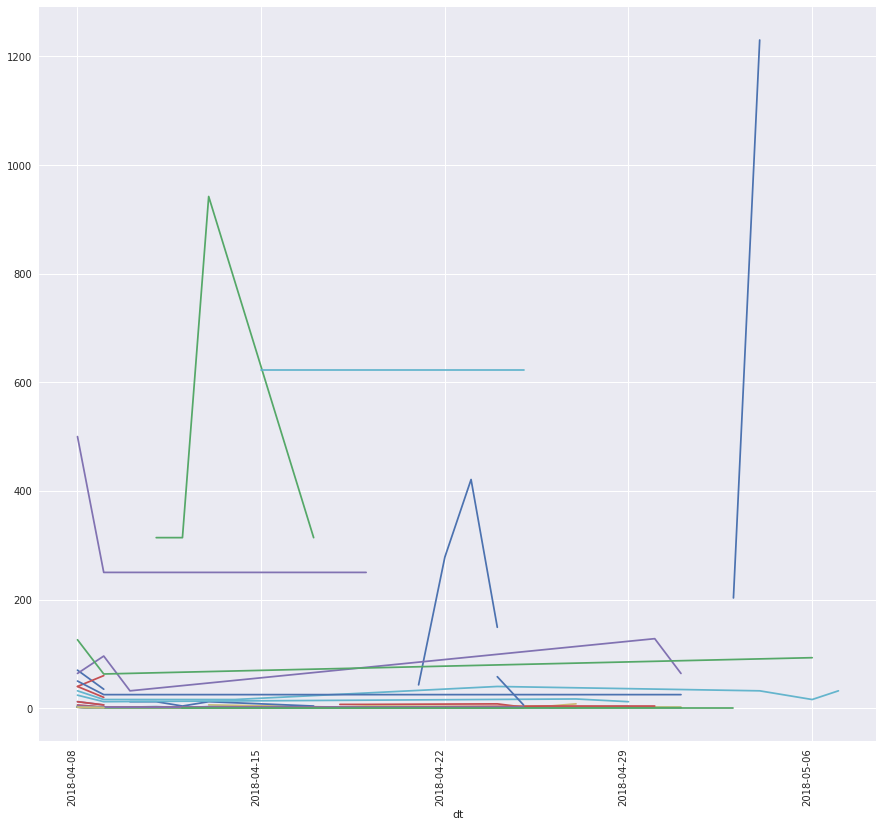

In [122]:
cleaned.set_index('dt', inplace=True)
grouped_cleaned = cleaned.groupby('dataset')
grouped_cleaned['count(1)'].plot(legend=False, rot=90, figsize=(15,15))

[Text(0,0,u'data10_hi'),
 Text(0,0,u'data13_hip'),
 Text(0,0,u'data15_13TeV'),
 Text(0,0,u'data15_5TeV'),
 Text(0,0,u'data15_hi'),
 Text(0,0,u'data16_13TeV'),
 Text(0,0,u'data17_13TeV'),
 Text(0,0,u'data17_5TeV'),
 Text(0,0,u'data17_comm'),
 Text(0,0,u'data18_13TeV'),
 Text(0,0,u'data18_comm'),
 Text(0,0,u'mc12_14TeV'),
 Text(0,0,u'mc12_8TeV'),
 Text(0,0,u'mc15_13TeV'),
 Text(0,0,u'mc15_14TeV'),
 Text(0,0,u'mc15_5TeV'),
 Text(0,0,u'mc15_7TeV'),
 Text(0,0,u'mc15_8TeV'),
 Text(0,0,u'mc15_pPb8TeV'),
 Text(0,0,u'mc15_valid'),
 Text(0,0,u'mc16_13TeV'),
 Text(0,0,u'mc16_5TeV'),
 Text(0,0,u'mc16_5p44TeV'),
 Text(0,0,u'mc16_valid')]

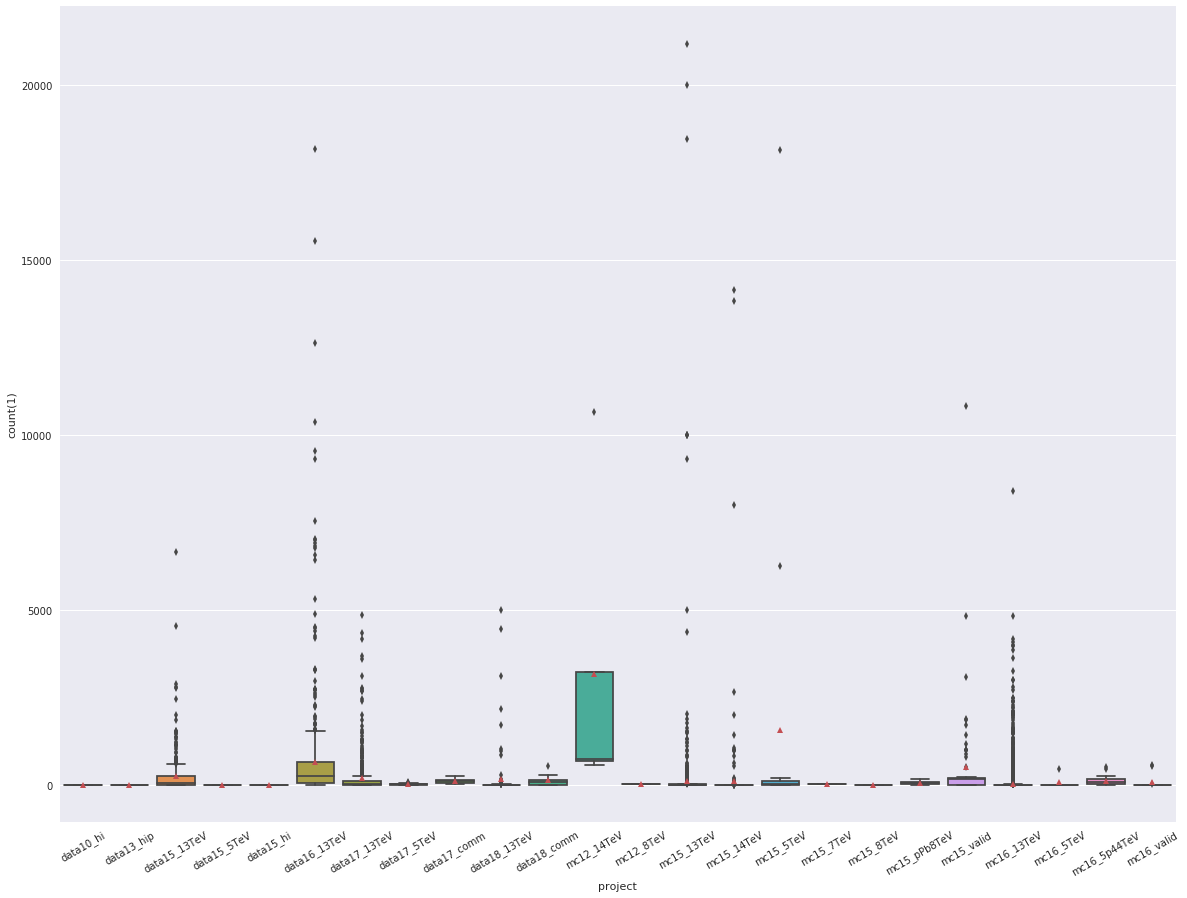

In [123]:
temp_big = df_pandas.dataset.str.split('.', expand=True)
temp_big.columns = ["project", "run_number", "stream_name", "prod_step", "datatype", "version"]
temp_big_c = pd.concat([df_pandas.reset_index(drop=True), temp_big.reset_index(drop=True)], axis=1)

plt.subplots(figsize=(20,15))
plot = sns.boxplot(x=temp_big_c['project'], y=temp_big_c['count(1)'], showmeans=True)
plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
